In [1]:
# ==============================================================================
# 0. SZEKCIÓ: KÖRNYEZET BEÁLLÍTÁSA ÉS CSOMAGOK BETÖLTÉSE
# ==============================================================================
# Szükséges csomagok telepítése (ha még nem történt meg)
# install.packages(c("bsvars", "ggplot2", "dplyr", "tidyr", "lubridate", "rhdf5", "patchwork", "ggdist"))

install.packages(c('bsvars', 'RcppTN', 'GIGrvg', 'stochvol'), repos = c('https://bsvars.r-universe.dev', 'https://cloud.r-project.org'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# Csomagok betöltése
library(bsvars)
library(ggplot2)
library(dplyr)
library(tidyr)
library(lubridate)
library(rhdf5)
library(patchwork)
library(ggdist) # Az elegáns fanchartokhoz

# Vizuális beállítások
theme_set(theme_bw() + theme(plot.title = element_text(hjust = 0.5)))

# Kimeneti mappa
output_dir <- "eredmenyek_bsvars"
if (!dir.exists(output_dir)) {
  dir.create(output_dir)
}
cat(sprintf("Minden kimenet a '%s/' mappába lesz mentve.\n", output_dir))


# ==============================================================================
# 1. SZEKCIÓ: ADATOK BETÖLTÉSE ÉS ELŐKÉSZÍTÉSE
# ==============================================================================
cat("\n--- 1. Adatok betöltése és előkészítése ---\n")

data_path <- "/kaggle/input/download-etf-macro-data-in-python/financial_factors.csv.gz"
meta_path <- "/kaggle/input/download-etf-macro-data-in-python/financial_factors_meta.csv.gz"

etf_meta_df <- read.csv(meta_path)
all_factors_df <- read.csv(data_path, row.names = "Date")
all_factors_df$Date <- ymd(rownames(all_factors_df))

asset_symbols <- etf_meta_df %>%
  filter(type == 'asset_return' | asset_class == 'MACRO') %>%
  pull(symbol) |> gsub("\\^", "X.", x = _)
hist_returns <- all_factors_df[, c(asset_symbols, "Date")]

Y <- as.matrix(hist_returns[, asset_symbols])
T_ <- nrow(Y)
D <- ncol(Y)
cat(sprintf("A modell bemeneti mátrixának (Y) mérete: %d időpont, %d eszköz.\n", T_, D))


Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





Attaching package: ‘lubridate’




The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




Minden kimenet a 'eredmenyek_bsvars/' mappába lesz mentve.



--- 1. Adatok betöltése és előkészítése ---


A modell bemeneti mátrixának (Y) mérete: 220 időpont, 14 eszköz.


In [3]:
# ==============================================================================
# 2. SZEKCIÓ: BVAR-SV MODELL BECSLÉSE
# ==============================================================================
cat("\n--- 2. BVAR-SV modell becslése ---\n")

set.seed(123)
start_time <- Sys.time()
cat("BVAR-SV modell becslése... (ez eltarthat egy ideig)\n")

specification <- specify_bsvar_msh$new(data = Y, p = 1)
burn_in <- estimate(specification, S = 2500, show_progress = TRUE)
posterior <- estimate(burn_in, S = 5000, show_progress = TRUE)

end_time <- Sys.time()
cat(sprintf("A modell becslése %.1f perc alatt befejeződött.\n", as.numeric(end_time - start_time, units = "mins")))


--- 2. BVAR-SV modell becslése ---


BVAR-SV modell becslése... (ez eltarthat egy ideig)


The identification is set to the default option of lower-triangular structural matrix.



**************************************************|
bsvars: Bayesian Structural Vector Autoregressions|
**************************************************|
 Gibbs sampler for the SVAR-stationaryMSH model             |
**************************************************|
 Progress of the MCMC simulation for 2500 draws
    Every draw is saved via MCMC thinning
 Press Esc to interrupt the computations
**************************************************|


**************************************************|
bsvars: Bayesian Structural Vector Autoregressions|
**************************************************|
 Gibbs sampler for the SVAR-stationaryMSH model             |
**************************************************|
 Progress of the MCMC simulation for 5000 draws
    Every draw is saved via MCMC thinning
 Press Esc to interrupt the computations
**************************************************|


A modell becslése 14.9 perc alatt befejeződött.



--- 3. Poszterior diagnosztika ---


 **************************************************|
 bsvars: Bayesian Structural Vector Autoregressions|
 **************************************************|
   Posterior summary of the parameters             |
 **************************************************|


$B
$B$equation1
           mean       sd 5% quantile 95% quantile
B[1,1] 963.1622 88.54358    819.3379     1107.853

$B$equation2
             mean        sd 5% quantile 95% quantile
B[2,1] -0.8307164 35.128308   -56.80418     56.40232
B[2,2] 19.1763826  1.486172    16.69592     21.62842

$B$equation3
            mean        sd 5% quantile 95% quantile
B[3,1]   4.64257 37.164681   -54.45603     68.35889
B[3,2] -42.18315  3.086627   -47.17572    -36.96101
B[3,3]  35.97270  2.304769    32.06845     39.66425

$B$equation4
             mean        sd 5% quantile 95% quantile
B[4,1]  25.592521 36.230392  -27.023368    89.397506
B[4,2] -12.461563  2.926640  -17.456485    -7.688297
B[4,3]  -6.001376  2.116341   -9.518546    -2.600512
B[4,4]  20.755305  1.818244   17.731187    23.735337

$B$equation5
             mean        sd 5% quantile 95% quantile
B[5,1] -18.504113 34.221365 -76.9438020    33.440772
B[5,2]  -1.337073  3.248554  -6.7441497     3.953138
B[5,3]   4.442399  2.379867   0.69978


--- 4. Poszterior prediktív szimulációk (PPC) ---


Sikeresen generáltunk 60 lépéses szcenáriót.


A szcenárió tömb mérete: 14 x 60 x 5000



--- 5. Vizualizáció és eredmények értelmezése ---


Fanchart ábra készítése ggdist segítségével...


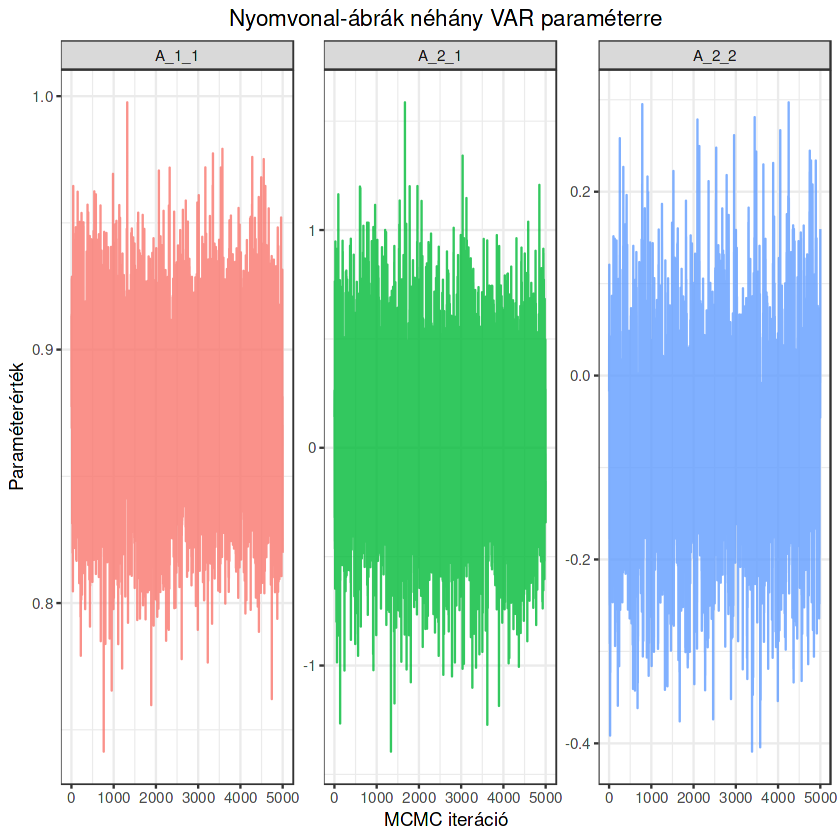

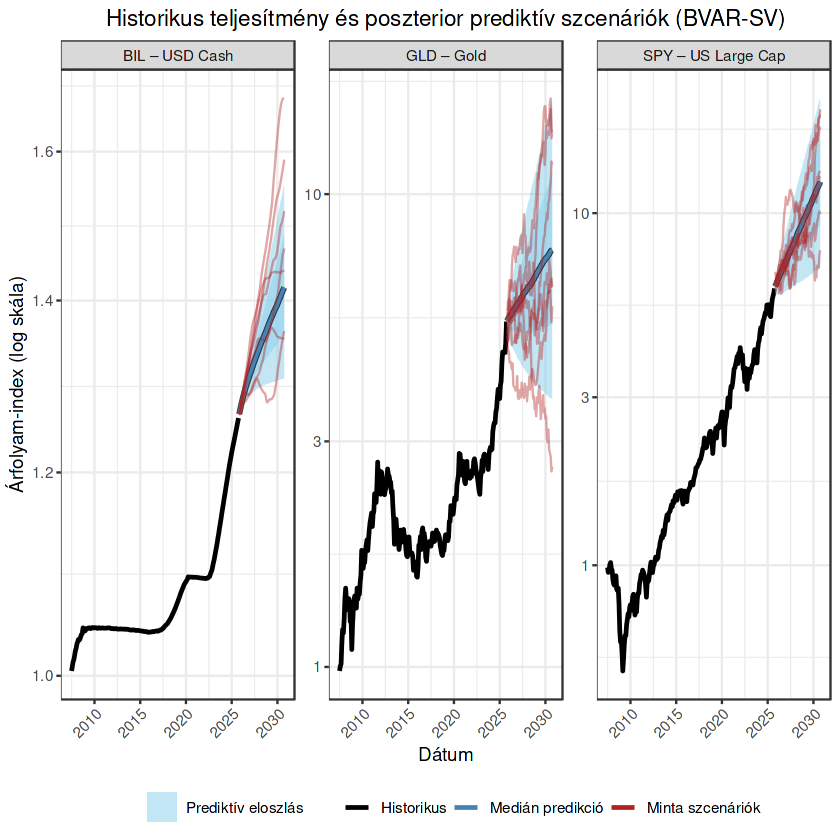


--- Időben változó volatilitás ábra készítése (SV és MSH kompatibilis) ---


MSH modell detektálva, a 'sigma' (szórás) tömböt használjuk.


A poszterior átlag volatilitás sikeresen kiszámítva.


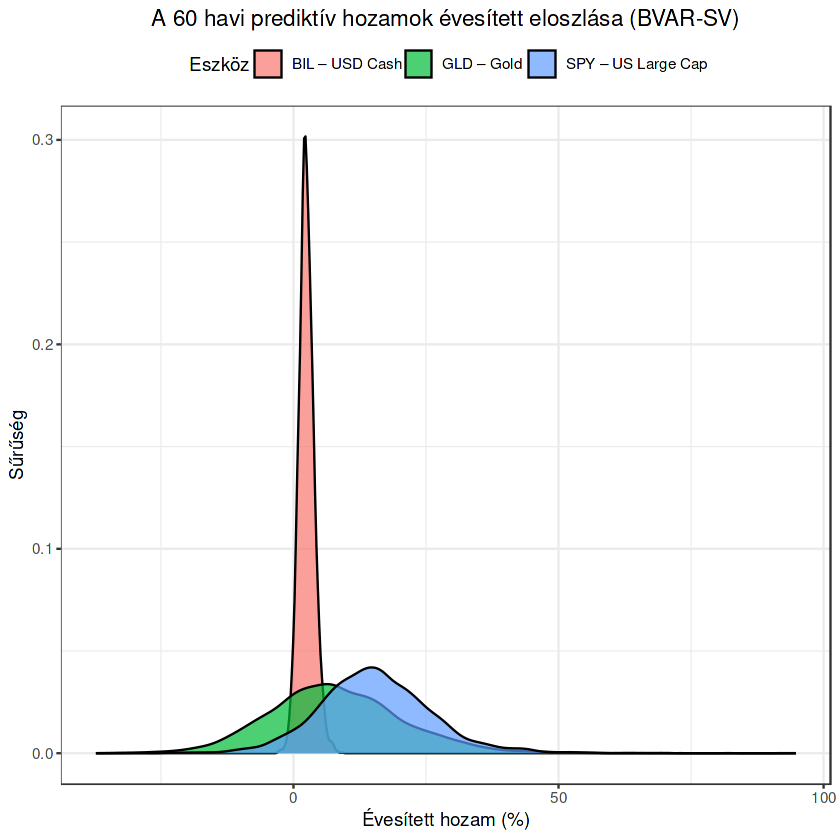


--- 6. Eredmények mentése ---


You created a large dataset with compression and chunking.
The chunk size is equal to the dataset dimensions.
If you want to read subsets of the dataset, you should testsmaller chunk sizes to improve read times.



A PPC szcenáriók elmentve HDF5 formátumban: eredmenyek_bsvars/ppc_scenarios_bsvars.h5


A teljes modell objektum (posterior) elmentve.



A `bsvars` munkafolyamat sikeresen lezárult.


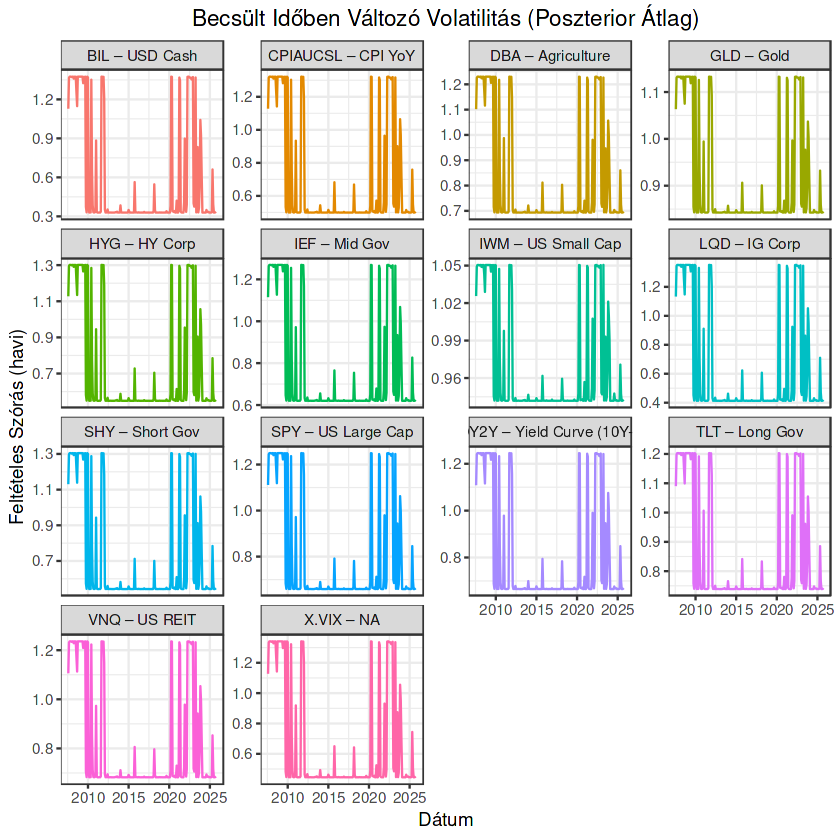

In [4]:
# ==============================================================================
# 3. SZEKCIÓ: POSZTERIOR DIAGNOSZTIKA
# ==============================================================================
cat("\n--- 3. Poszterior diagnosztika ---\n")

summary_fit <- summary(posterior)
print(summary_fit)
#plot(posterior, type = "regime")

n_samples <- dim(posterior$posterior$A)[3]
trace_data <- data.frame(
  Iteration = 1:n_samples,
  A_1_1 = posterior$posterior$A[1, 1, ], # BIL hatása saját magára
  A_2_1 = posterior$posterior$A[2, 1, ], # BIL hatása SPY-ra
  A_2_2 = posterior$posterior$A[2, 2, ]  # SPY hatása saját magára
) %>%
  pivot_longer(-Iteration, names_to = "Parameter", values_to = "Value")

p_trace <- ggplot(trace_data, aes(x = Iteration, y = Value, color = Parameter)) +
  geom_line(alpha = 0.8) +
  facet_wrap(~Parameter, scales = "free_y") +
  labs(title = "Nyomvonal-ábrák néhány VAR paraméterre", x = "MCMC iteráció", y = "Paraméterérték") +
  theme(legend.position = "none")

print(p_trace)
ggsave(file.path(output_dir, "diag_bsvars_trace.png"), p_trace, width = 10, height = 4)


# ==============================================================================
# 4. SZEKCIÓ: POSZTERIOR PREDIKTÍV SZIMULÁCIÓK (PPC)
# ==============================================================================
cat("\n--- 4. Poszterior prediktív szimulációk (PPC) ---\n")
n_steps <- 60
ppc_results <- forecast(posterior, horizon = n_steps)
# Dimenziók: (eszköz, lépés, szcenárió)
ppc_scenarios <- ppc_results$forecasts
cat(sprintf("Sikeresen generáltunk %d lépéses szcenáriót.\n", n_steps))
cat(sprintf("A szcenárió tömb mérete: %s\n", paste(dim(ppc_scenarios), collapse = " x ")))


# ==============================================================================
# 5. SZEKCIÓ: VIZUALIZÁCIÓ ÉS EREDMÉNYEK ÉRTELMEZÉSE (JAVÍTOTT)
# ==============================================================================
cat("\n--- 5. Vizualizáció és eredmények értelmezése ---\n")

name_map <- setNames(etf_meta_df$name, etf_meta_df$symbol)
label_for <- function(ticker) sprintf("%s – %s", ticker, name_map[ticker])
assets_to_plot <- c("BIL", "SPY", "GLD")

# 5.1. Ábra: Kombinált historikus és PPC "fanchart" (ggdist-tel)
# -----------------------------------------------------------------------
cat("Fanchart ábra készítése ggdist segítségével...\n")
last_hist_date <- tail(hist_returns$Date, 1)
future_dates <- seq(from = last_hist_date, by = "month", length.out = n_steps + 1)[-1]
n_trajectories_to_plot <- 7

# Historikus adatok előkészítése
hist_cum_df <- hist_returns %>%
  select(all_of(c(assets_to_plot, "Date"))) %>%
  pivot_longer(-Date, names_to = "Asset", values_to = "Return") %>%
  group_by(Asset) %>%
  mutate(Cumulative = cumprod(1 + Return))

# PPC adatok előkészítése "tidy" formátumba a ggdist számára
dimnames(ppc_scenarios) <- list(Asset = colnames(Y), Step = 1:n_steps, Draw = 1:n_samples)
ppc_long_df <- as.data.frame.table(ppc_scenarios, responseName = "Return") %>%
  mutate(Step = as.integer(Step)) %>%
  filter(Asset %in% assets_to_plot)

# Kumulált hozamok számítása minden egyes szcenárióra
last_cum_values <- hist_cum_df %>% group_by(Asset) %>% summarise(LastCum = last(Cumulative), .groups = 'drop')
ppc_cum_df <- ppc_long_df %>%
  group_by(Asset, Draw) %>%
  arrange(Step) %>%
  mutate(CumulativeReturn = cumprod(1 + Return)) %>%
  ungroup() %>%
  left_join(last_cum_values, by = "Asset") %>%
  mutate(CumulativeValue = CumulativeReturn * LastCum,
         Date = future_dates[Step])

# Az ábra összeállítása `stat_lineribbon`-nal
p_fanchart <- ggplot(ppc_cum_df, aes(x = Date, y = CumulativeValue)) +
  # Historikus adatok
  geom_line(data = hist_cum_df, aes(y = Cumulative, color = "Historikus"), linewidth = 1) +
  # ggdist lineribbon a bizonytalansági sávokhoz
  stat_lineribbon(aes(fill = "Prediktív eloszlás"), .width = c(.5, .8), alpha = 0.5) +
  # Medián predikció vonala
  stat_summary(fun = median, geom = "line", aes(color = "Medián predikció"), linewidth = 0.8) +
  # Néhány minta trajektória
  geom_line(data = filter(ppc_cum_df, Draw %in% 1:n_trajectories_to_plot),
            aes(group = Draw, color = "Minta szcenáriók"), linewidth = 0.5, alpha = 0.4) +
  # Facet-ek és skálák
  facet_wrap(~Asset, scales = "free_y", labeller = as_labeller(label_for)) +
  scale_y_log10() +
  scale_color_manual(name = "", values = c("Historikus" = "black", "Minta szcenáriók" = "firebrick", "Medián predikció" = "steelblue")) +
  scale_fill_manual(name = "", values = c("Prediktív eloszlás" = "skyblue")) +
  guides(color = guide_legend(override.aes = list(linewidth = 1, alpha=1))) +
  labs(title = "Historikus teljesítmény és poszterior prediktív szcenáriók (BVAR-SV)", x = "Dátum", y = "Árfolyam-index (log skála)") +
  theme(legend.position = "bottom", axis.text.x = element_text(angle = 45, hjust = 1))

print(p_fanchart)
ggsave(file.path(output_dir, "viz_bsvars_fanchart_ggdist.png"), p_fanchart, width = 12, height = 6)

# 5.2. Ábra: Évesített PPC hozamok eloszlása (JAVÍTOTT)
# ---------------------------------------------------------
# JAVÍTÁS: Az `apply` helyes margója c(1, 3), hogy az eszközökön és szcenáriókon
# iteráljon, és a függvényt a lépések (dim 2) mentén alkalmazza.
annualized_returns_matrix <- apply(ppc_scenarios, c(1, 3), function(x) {
    (prod(1 + x))^(12 / n_steps) - 1
  }) # Ennek eredménye egy (eszköz x szcenárió) mátrix

# A mátrixot most már helyesen tudjuk data frame-mé alakítani és pivotálni
annualized_returns_df <- as.data.frame(t(annualized_returns_matrix)) %>% # Transzponálás, hogy az oszlopok az eszközök legyenek
  `colnames<-`(colnames(Y)) %>%
  pivot_longer(everything(), names_to = "Asset", values_to = "AnnualizedReturn") %>%
  filter(Asset %in% assets_to_plot)

p_density <- ggplot(annualized_returns_df, aes(x = AnnualizedReturn * 100, fill = Asset)) +
  geom_density(alpha = 0.7) +
  scale_fill_discrete(name = "Eszköz", labels = sapply(assets_to_plot, label_for)) +
  labs(
    title = sprintf("A %d havi prediktív hozamok évesített eloszlása (BVAR-SV)", n_steps),
    x = "Évesített hozam (%)", y = "Sűrűség"
  ) +
  theme(legend.position = "top")

print(p_density)
ggsave(file.path(output_dir, "viz_bsvars_annualized_dist.png"), p_density, width = 10, height = 5)

# ==============================================================================
# 5.3. Ábra: Időben változó volatilitás (JAVÍTOTT ÉS ROBUSZTUS)
# Ez a kód most már működik mind a BSVAR-SV, mind a BSVAR-MSH modellekkel.
# ==============================================================================
cat("\n--- Időben változó volatilitás ábra készítése (SV és MSH kompatibilis) ---\n")

# --- 1. Lépés: Helyes adatforrás kiválasztása a posterior objektumból ---
# Ellenőrizzük, hogy SV (h) vagy MSH (sigma) modellt futtattunk-e.

if ("h" %in% names(posterior$posterior)) {
  cat("SV modell detektálva, a 'h' (log-volatilitás) tömböt használjuk.\n")
  # SV modell esetén a sigma_t = exp(h_t / 2)
  volatility_draws <- exp(posterior$posterior$h / 2)
} else if ("sigma" %in% names(posterior$posterior)) {
  cat("MSH modell detektálva, a 'sigma' (szórás) tömböt használjuk.\n")
  # MSH modell esetén a 'sigma' már a kész szórás-értékeket tartalmazza
  volatility_draws <- posterior$posterior$sigma
} else {
  stop("Nem található sem 'h', sem 'sigma' a posterior objektumban. A volatilitás nem elemezhető.")
}

# --- 2. Lépés: A poszterior átlag volatilitás kiszámítása ---
# A 3D-s tömböt (Eszköz x Időpont x Minta) átlagoljuk a 3. (Minta) dimenzió mentén.
mean_volatility_matrix <- apply(volatility_draws, c(1, 2), mean)
cat("A poszterior átlag volatilitás sikeresen kiszámítva.\n")

# --- 3. Lépés: Adatkeret előkészítése a ggplot számára ---
# A (Eszköz x Időpont) mátrixot alakítjuk hosszú (tidy) formátumra
# A dátumokat a modellben használt idősorhoz igazítjuk
vol_dates <- tail(hist_returns$Date, ncol(mean_volatility_matrix))

volatility_df_final <- as.data.frame(t(mean_volatility_matrix)) %>%
  setNames(colnames(Y)) %>%
  mutate(Date = vol_dates) %>%
  pivot_longer(
    cols = -Date,
    names_to = "Asset",
    values_to = "Volatility"
  )

# --- 4. Lépés: Az ábra létrehozása ---
p_volatility <- ggplot(volatility_df_final, aes(x = Date, y = Volatility)) +
  geom_line(aes(color = Asset)) +
  facet_wrap(~Asset, scales = "free_y", labeller = as_labeller(label_for)) +
  labs(
    title = "Becsült Időben Változó Volatilitás (Poszterior Átlag)",
    x = "Dátum", y = "Feltételes Szórás (havi)", color = "Eszköz"
  ) +
  theme_bw() +
  theme(legend.position = "none", plot.title = element_text(hjust = 0.5))

print(p_volatility)
ggsave(file.path(output_dir, "viz_bsvars_volatility.png"), p_volatility, width = 12, height = 6)
# ==============================================================================
# 6. SZEKCIÓ: EREDMÉNYEK MENTÉSE
# ==============================================================================
cat("\n--- 6. Eredmények mentése ---\n")

h5_path <- file.path(output_dir, "ppc_scenarios_bsvars.h5")
if(file.exists(h5_path)) file.remove(h5_path)
h5createFile(h5_path)
h5write(ppc_scenarios, h5_path, "scenarios")
cat(sprintf("A PPC szcenáriók elmentve HDF5 formátumban: %s\n", h5_path))

saveRDS(posterior, file.path(output_dir, "fit_bsvars_posterior.rds"))
cat("A teljes modell objektum (posterior) elmentve.\n")

cat("\nA `bsvars` munkafolyamat sikeresen lezárult.\n")

In [5]:
# Győződj meg róla, hogy a 'posterior' objektum létezik
# Először telepíteni és betölteni kell a 'lubridate' csomagot a dátumkezeléshez, ha még nem történt meg
# install.packages("lubridate")
library(lubridate)

# Számoljuk ki a simított rezsim-valószínűségeket
# Ez egy tömböt ad vissza: (Rezsim, Időpont, MCMC minta)
regime_probs_draws <- compute_regime_probabilities(posterior, type = "smoothed")

# Átlagoljuk az MCMC minták mentén, hogy megkapjuk a poszterior átlag valószínűségeket
# Az eredmény egy (Rezsim x Időpont) mátrix lesz
mean_regime_probs <- apply(regime_probs_draws, c(1, 2), mean)

# Alakítsuk át egy ggplot-barát data frame-mé
n_regimes <- dim(mean_regime_probs)[1]
n_obs <- dim(mean_regime_probs)[2]

# Hozzunk létre egy dátumvektort, ami megegyezik a modellben használt adatokkal
# A 'Y' mátrixot a specifikációból nyerjük ki, a rownames-nek dátumoknak kell lenniük
# VAGY a hist_returns-ből
start_date <- head(hist_returns$Date, 1)
# Az Y mátrix mérete T, a valószínűségeké T-p. Igazítsuk ehhez!
model_dates <- hist_returns$Date[(posterior$last_draw$p + 1):nrow(hist_returns)]

probs_df <- data.frame(
  Date = rep(model_dates, each = n_regimes),
  Probability = as.vector(mean_regime_probs),
  Regime = as.factor(rep(1:n_regimes, times = n_obs))
)

cat("A rezsim-valószínűségek sikeresen kinyerve és előkészítve az ábrázoláshoz.\n")

A rezsim-valószínűségek sikeresen kinyerve és előkészítve az ábrázoláshoz.


A modell a(z) 1. rezsimet azonosította magas volatilitásúként.



--- Átlagos Átmeneti Mátrix (P) ---


        To_R1 To_R2
From_R1 0.762 0.238
From_R2 0.073 0.927



A magas volatilitású rezsim (1) perzisztenciája (P_ii): 76.2%


A nyugodt rezsim perzisztenciája (P_jj): 92.7%



--- Évesített Volatilitás az Egyes Rezsimekben ---


         Regime_1 Regime_2
BIL         4.763    1.147
SPY         4.330    2.292
IWM         3.646    3.272
VNQ         4.284    2.377
GLD         3.928    2.928
DBA         4.264    2.412
SHY         4.520    1.890
IEF         4.397    2.159
TLT         4.170    2.572
LQD         4.683    1.439
HYG         4.509    1.916
X.VIX       4.646    1.555
T10Y2Y      4.316    2.318
CPIAUCSL    4.579    1.741


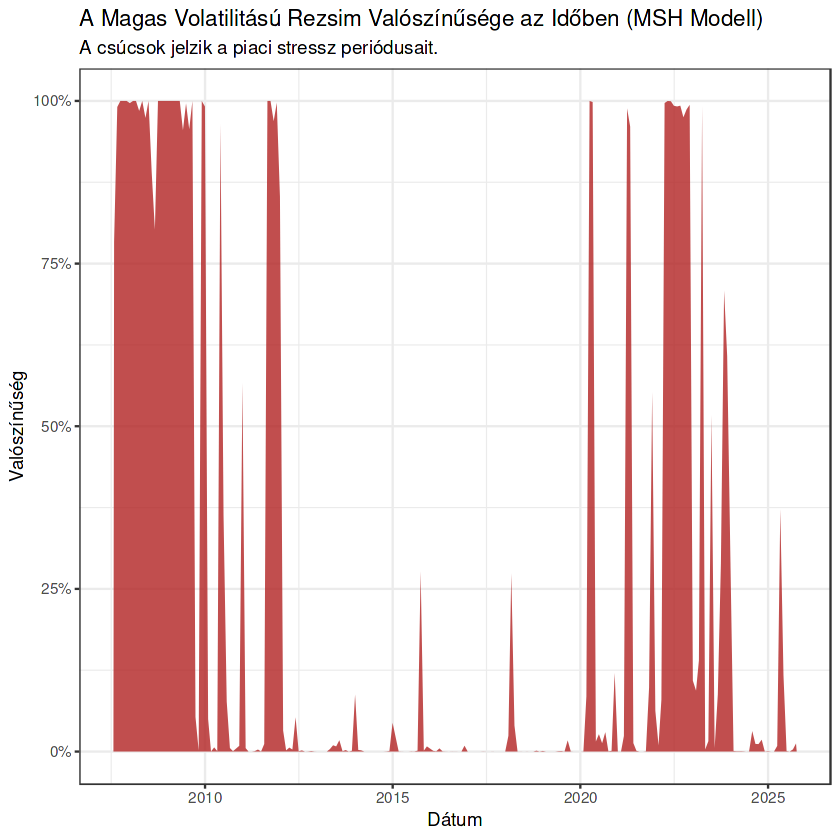

In [6]:
# Azonosítsuk a magas volatilitású rezsimet
# A sigma2 egy (Eszköz x Rezsim x Minta) tömb
# Számoljuk ki az átlagos volatilitást rezsimenként (pl. az SPY volatilitása alapján)
spy_index <- which(colnames(Y) == "SPY")
vol_by_regime <- apply(posterior$posterior$sigma2[spy_index, , ], 1, mean)
high_vol_regime <- which.max(vol_by_regime)

cat(sprintf("A modell a(z) %d. rezsimet azonosította magas volatilitásúként.\n", high_vol_regime))

# Ábrázoljuk a magas volatilitású rezsim valószínűségét
library(ggplot2)

p_regimes <- ggplot(subset(probs_df, Regime == high_vol_regime), aes(x = Date, y = Probability)) +
  geom_area(fill = "firebrick", alpha = 0.8) +
  labs(
    title = "A Magas Volatilitású Rezsim Valószínűsége az Időben (MSH Modell)",
    subtitle = "A csúcsok jelzik a piaci stressz periódusait.",
    x = "Dátum",
    y = "Valószínűség"
  ) +
  scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
  theme_bw()

print(p_regimes)

# --- Rezsim-perzisztencia ---
# A PR_TR egy (Rezsim x Rezsim x Minta) tömb, ami az átmeneti mátrixokat tartalmazza
# Vegyük az átlagos átmeneti mátrixot
transition_matrix <- apply(posterior$posterior$PR_TR, c(1, 2), mean)
colnames(transition_matrix) <- paste0("To_R", 1:n_regimes)
rownames(transition_matrix) <- paste0("From_R", 1:n_regimes)

cat("\n--- Átlagos Átmeneti Mátrix (P) ---\n")
print(round(transition_matrix, 3))

cat(sprintf("\nA magas volatilitású rezsim (%d) perzisztenciája (P_ii): %.1f%%\n", 
            high_vol_regime, 
            transition_matrix[high_vol_regime, high_vol_regime] * 100))
cat(sprintf("A nyugodt rezsim perzisztenciája (P_jj): %.1f%%\n", 
            transition_matrix[-high_vol_regime, -high_vol_regime] * 100))


# --- Volatilitás a Rezsimekben ---
# A sigma2 egy (Eszköz x Rezsim x Minta) tömb. A volatilitás ennek a négyzete.
mean_vol_by_regime <- sqrt(apply(posterior$posterior$sigma2, c(1, 2), mean)) * sqrt(12) # Évesítve
rownames(mean_vol_by_regime) <- colnames(Y)
colnames(mean_vol_by_regime) <- paste0("Regime_", 1:n_regimes)

cat("\n--- Évesített Volatilitás az Egyes Rezsimekben ---\n")
print(round(mean_vol_by_regime, 3))